# Segmentation of household customers by energy consumption in Greece

<big><font color="grey"><b>Aksana Lefter</b></font></big>

Utilizing a dataset containing important information on household energy consumption patterns in Greece from 2004 to 2020, we conduct customer segmentation.

## Data analysis

Loading data and libraries.

In [1]:
# Library installation
!pip install pandas -q
!pip install numpy -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install requests -q

In [2]:
# Library import
import requests
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data first 7 lines
try:
    data = pd.read_excel("HBS_final.xlsx")
    print("uploaded locally")
except FileNotFoundError:
    file_id = '1W0HQTa4E2NgkNhAVgoOsx4I_OGiwodjF'
    url = f'https://drive.google.com/uc?id={file_id}'
    output = 'HBS_finall.xlsx'

    try:
        response = requests.get(url)
        with open(output, 'wb') as f:
            f.write(response.content)
        print("data downloaded")
        data = pd.read_excel(output)
    except Exception as e:
        print(f"An error occurred during download: {str(e)}")

data.head(7)

uploaded locally


,Column1,Year,Hh_ID,Type_energy,Quantity,Expenditure,Unit_cost,Location,Mean_winter_temp,Month,...,Camera,Game,HiFi,Fridge,Freezer,Wash,DishWash,Solar_water,Mobile,PC
0,1,2004,1_2004,Oil,0.37,125.0,337.837838,Attica,11.181667,1.0,...,1,0,1,1,0,1,0,0,1,1
1,2,2004,1_2004,Electr_1,1730.00,149.9,0.086647,Attica,11.181667,1.0,...,1,0,1,1,0,1,0,0,1,1
2,3,2004,10_2004,Oil,2.50,875.0,350.000000,Attica,11.181667,2.0,...,0,0,1,1,0,1,1,0,0,0
3,4,2004,10_2004,Electr_1,2810.00,207.5,0.073843,Attica,11.181667,2.0,...,0,0,1,1,0,1,1,0,0,0
4,5,2004,100_2004,Oil,2.83,850.0,300.353357,Attica,11.181667,1.0,...,0,0,0,0,0,1,0,0,1,0
5,6,2004,100_2004,Electr_1,4670.00,408.8,0.087537,Attica,11.181667,1.0,...,0,0,0,0,0,1,0,0,1,0
6,7,2004,1000_2004,Oil,0.63,200.0,317.460317,Attica,11.181667,4.0,...,0,0,0,1,1,1,0,0,1,0


Let's delete the unnecessary column Column1 right away.

In [4]:
data = data.drop(columns='Column1') 

Check dataset for duplicates.

In [5]:
print(f'There are {data.duplicated().sum()} duplicates in our dataframe.')

There are 0 duplicates in our dataframe.


Let's take a look at the columns and what information they contain.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136530 entries, 0 to 136529
Data columns (total 56 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Year              136530 non-null  int64  
 1   Hh_ID             136530 non-null  object 
 2   Type_energy       136530 non-null  object 
 3   Quantity          136530 non-null  float64
 4   Expenditure       136530 non-null  float64
 5   Unit_cost         136530 non-null  float64
 6   Location          136530 non-null  object 
 7   Mean_winter_temp  135843 non-null  float64
 8   Month             127737 non-null  float64
 9   Urb_degree        132993 non-null  float64
 10  Biomass           136530 non-null  bool   
 11  Biomass_only      136530 non-null  bool   
 12  Biomass_number    136530 non-null  int64  
 13  Biomass_main      136530 non-null  int64  
 14  Wood              136530 non-null  bool   
 15  Wood_only         136530 non-null  bool   
 16  Wood_main         13

Let's check the dataset for missing data.

In [7]:
data.isnull().sum()

Year                   0
Hh_ID                  0
Type_energy            0
Quantity               0
Expenditure            0
Unit_cost              0
Location               0
Mean_winter_temp     687
Month               8793
Urb_degree          3537
Biomass                0
Biomass_only           0
Biomass_number         0
Biomass_main           0
Wood                   0
Wood_only              0
Wood_main              0
Pellet                 0
Pellet_only            0
Pellet_main            0
Briqs                  0
Briqs_only             0
Briqs_main             0
Kernel                 0
Kernel_only            0
Kernel_main            0
Heating                0
Cook                   0
Cook_type              0
Heating_type           0
Hh_size                0
Gender_head            0
Age_head               0
Activity_head          0
Employed               0
Unemployed             0
Retired                0
Non_active             0
HH_income              0
Children               0


The Month column has missing data, it's only somewhere around 6 percent, so we'll just delete it.

In [8]:
data.dropna(subset=['Month'], inplace=True)

Let's also delete missing data in the column Urb_degree.

In [9]:
data.dropna(subset=['Urb_degree'], inplace=True)

We also have missing data in the column Mean_winter_temp. Take a look at them and see if we can recover anything. 

In [10]:
filtered_data = data.loc[data['Mean_winter_temp'].isna()]
filtered_data

,Year,Hh_ID,Type_energy,Quantity,Expenditure,Unit_cost,Location,Mean_winter_temp,Month,Urb_degree,...,Camera,Game,HiFi,Fridge,Freezer,Wash,DishWash,Solar_water,Mobile,PC
40747,2011,33701_2011,Oil,2.67,1916.70,717.865169,Western_Macedonia,NaN,6.0,3.0,...,0,0,0,1,0,1,0,0,1,0
40748,2011,33701_2011,Electr_1,2340.00,172.50,0.073718,Western_Macedonia,NaN,6.0,3.0,...,0,0,0,1,0,1,0,0,1,0
40749,2011,33702_2011,Oil,1.00,710.00,710.000000,Western_Macedonia,NaN,6.0,3.0,...,0,0,0,1,0,1,0,0,1,0
40750,2011,33702_2011,Liq_gas,1652.00,5.22,0.003160,Western_Macedonia,NaN,6.0,3.0,...,0,0,0,1,0,1,0,0,1,0
40751,2011,33702_2011,Electr_1,1230.00,102.10,0.083008,Western_Macedonia,NaN,6.0,3.0,...,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55106,2013,28706_2013,Biomass,1250.00,187.50,0.150000,Epirus,NaN,11.0,3.0,...,0,0,0,1,1,1,0,0,1,0
55107,2013,28706_2013,Electr_1,3720.00,372.30,0.100081,Epirus,NaN,11.0,3.0,...,0,0,0,1,1,1,0,0,1,0
55108,2013,28707_2013,Liq_gas,413.00,2.04,0.004939,Epirus,NaN,11.0,3.0,...,0,0,0,1,0,1,0,0,0,0
55109,2013,28707_2013,Biomass,250.00,37.50,0.150000,Epirus,NaN,11.0,3.0,...,0,0,0,1,0,1,0,0,0,0


So we see that there is missing data for 2013 and 2011 for the locations of Epirius and Western Macedonia. See if there are any other locations and years.

In [11]:
filtered_data['Year'].value_counts()

2013    432
2011    255
Name: Year, dtype: int64

In [12]:
filtered_data['Location'].value_counts()

Epirus               432
Western_Macedonia    255
Name: Location, dtype: int64

Only two years and two locations. Let's look at the average winter temperature at Epirius in 2012 and 2014 and take the average.

In [13]:
data.loc[(data['Year'] == 2012) & (data['Location'] == 'Epirus')]

,Year,Hh_ID,Type_energy,Quantity,Expenditure,Unit_cost,Location,Mean_winter_temp,Month,Urb_degree,...,Camera,Game,HiFi,Fridge,Freezer,Wash,DishWash,Solar_water,Mobile,PC
47221,2012,25701_2012,Oil,0.52,466.70,897.500000,Epirus,8.033333,1.0,1.0,...,0,0,0,1,1,1,0,0,1,0
47222,2012,25701_2012,Electr_1,2040.00,155.00,0.075980,Epirus,8.033333,1.0,1.0,...,0,0,0,1,1,1,0,0,1,0
47223,2012,25702_2012,Electr_1,3580.00,362.50,0.101257,Epirus,8.033333,1.0,1.0,...,0,0,1,1,0,1,1,0,0,0
47224,2012,25703_2012,Oil,0.83,750.00,903.614458,Epirus,8.033333,1.0,1.0,...,0,0,1,1,1,1,0,0,1,1
47225,2012,25703_2012,Electr_1,3480.00,350.20,0.100632,Epirus,8.033333,1.0,1.0,...,0,0,1,1,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47737,2012,28804_2012,Liq_gas,3333.00,6.33,0.001899,Epirus,8.033333,11.0,3.0,...,0,0,0,1,0,1,0,1,0,0
47738,2012,28804_2012,Biomass,350.00,63.33,0.180943,Epirus,8.033333,11.0,3.0,...,0,0,0,1,0,1,0,1,0,0
47739,2012,28804_2012,Electr_1,1390.00,119.80,0.086187,Epirus,8.033333,11.0,3.0,...,0,0,0,1,0,1,0,1,0,0
47740,2012,28805_2012,Biomass,625.00,120.83,0.193328,Epirus,8.033333,11.0,3.0,...,0,0,0,1,1,1,0,0,1,1


In [14]:
data.loc[(data['Year'] == 2014) & (data['Location'] == 'Epirus')]

,Year,Hh_ID,Type_energy,Quantity,Expenditure,Unit_cost,Location,Mean_winter_temp,Month,Urb_degree,...,Camera,Game,HiFi,Fridge,Freezer,Wash,DishWash,Solar_water,Mobile,PC


Since there is no data available in 2014. Then we simply replace with the average winter temperature for 2012.

In [15]:
data.loc[(data['Year'] == 2013) & (data['Location'] == 'Epirus'), 'Mean_winter_temp'] = \
data.loc[(data['Year'] == 2013) & (data['Location'] == 'Epirus'), 'Mean_winter_temp'].fillna(8.033)


Now let's look at Western Macedonia for 2010 and 2012.

In [16]:
data.loc[(data['Year'] == 2010) & (data['Location'] == 'Western_Macedonia')]

,Year,Hh_ID,Type_energy,Quantity,Expenditure,Unit_cost,Location,Mean_winter_temp,Month,Urb_degree,...,Camera,Game,HiFi,Fridge,Freezer,Wash,DishWash,Solar_water,Mobile,PC
32936,2010,33701_2010,Oil,2.18,1275.00,584.862385,Western_Macedonia,7.269167,9.0,3.0,...,0,0,0,1,0,1,0,0,1,0
32937,2010,33701_2010,Electr_1,2620.00,238.60,0.091069,Western_Macedonia,7.269167,9.0,3.0,...,0,0,0,1,0,1,0,0,1,0
32938,2010,33702_2010,Oil,1.35,775.00,574.074074,Western_Macedonia,7.269167,9.0,3.0,...,0,0,0,1,0,1,0,0,1,0
32939,2010,33702_2010,Electr_1,2400.00,219.40,0.091417,Western_Macedonia,7.269167,9.0,3.0,...,0,0,0,1,0,1,0,0,1,0
32940,2010,33703_2010,Oil,1.26,775.00,615.079365,Western_Macedonia,7.269167,9.0,3.0,...,0,1,1,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33222,2010,35604_2010,Biomass,3334.00,437.08,0.131098,Western_Macedonia,7.269167,5.0,3.0,...,0,0,1,1,1,1,1,1,1,1
33223,2010,35604_2010,Electr_1,8350.00,307.50,0.036826,Western_Macedonia,7.269167,5.0,3.0,...,0,0,1,1,1,1,1,1,1,1
33224,2010,35605_2010,Oil,3.60,2025.00,562.500000,Western_Macedonia,7.269167,5.0,3.0,...,0,0,0,1,1,1,0,1,1,0
33225,2010,35605_2010,Biomass,1083.00,137.50,0.126962,Western_Macedonia,7.269167,5.0,3.0,...,0,0,0,1,1,1,0,1,1,0


In [17]:
data.loc[(data['Year'] == 2012) & (data['Location'] == 'Western_Macedonia')]

,Year,Hh_ID,Type_energy,Quantity,Expenditure,Unit_cost,Location,Mean_winter_temp,Month,Urb_degree,...,Camera,Game,HiFi,Fridge,Freezer,Wash,DishWash,Solar_water,Mobile,PC
48505,2012,33701_2012,Oil,1.83,1666.70,910.765027,Western_Macedonia,5.187222,3.0,1.0,...,0,0,0,1,0,1,0,0,1,0
48506,2012,33701_2012,Electr_1,2060.00,156.60,0.076019,Western_Macedonia,5.187222,3.0,1.0,...,0,0,0,1,0,1,0,0,1,0
48507,2012,33702_2012,Oil,0.97,875.00,902.061856,Western_Macedonia,5.187222,3.0,1.0,...,0,0,0,1,0,1,0,0,1,0
48508,2012,33702_2012,Electr_1,1640.00,124.30,0.075793,Western_Macedonia,5.187222,3.0,1.0,...,0,0,0,1,0,1,0,0,1,0
48509,2012,33703_2012,Biomass,833.00,133.33,0.160060,Western_Macedonia,5.187222,3.0,1.0,...,0,0,0,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48777,2012,35604_2012,Biomass,833.00,137.50,0.165066,Western_Macedonia,5.187222,11.0,3.0,...,0,1,1,1,0,1,0,1,1,0
48778,2012,35604_2012,Electr_1,3000.00,248.10,0.082700,Western_Macedonia,5.187222,11.0,3.0,...,0,1,1,1,0,1,0,1,1,0
48779,2012,35605_2012,Oil,2.50,2083.30,833.320000,Western_Macedonia,5.187222,11.0,3.0,...,0,0,0,1,0,1,1,0,1,1
48780,2012,35605_2012,Biomass,250.00,50.00,0.200000,Western_Macedonia,5.187222,11.0,3.0,...,0,0,0,1,0,1,1,0,1,1


Replace with the average of these two years.

In [18]:
data.loc[(data['Year'] == 2011) & (data['Location'] == 'Western_Macedonia'), 'Mean_winter_temp'] = \
data.loc[(data['Year'] == 2011) & (data['Location'] == 'Western_Macedonia'), 'Mean_winter_temp'].fillna(6.23)

The dataset has False and True data, so we will replace them with 0 and 1, respectively.

In [19]:
data.replace({False: 0, True: 1}, inplace=True)

Also, in the Gender_head column, replace female with 0 and male with 1.

In [20]:
data['Gender_head'].replace({"Female": 0, "Male": 1}, inplace=True)

Let's check again for missing data for control.

In [21]:
data.isnull().sum()

Year                0
Hh_ID               0
Type_energy         0
Quantity            0
Expenditure         0
Unit_cost           0
Location            0
Mean_winter_temp    0
Month               0
Urb_degree          0
Biomass             0
Biomass_only        0
Biomass_number      0
Biomass_main        0
Wood                0
Wood_only           0
Wood_main           0
Pellet              0
Pellet_only         0
Pellet_main         0
Briqs               0
Briqs_only          0
Briqs_main          0
Kernel              0
Kernel_only         0
Kernel_main         0
Heating             0
Cook                0
Cook_type           0
Heating_type        0
Hh_size             0
Gender_head         0
Age_head            0
Activity_head       0
Employed            0
Unemployed          0
Retired             0
Non_active          0
HH_income           0
Children            0
Kid_mean_age        0
Baby                0
Hh_mean_age         0
Car                 0
TV                  0
DVD       

Now the dataset is without missing data. Let's start visualization. First, let's look at energy consumption by year and by type.

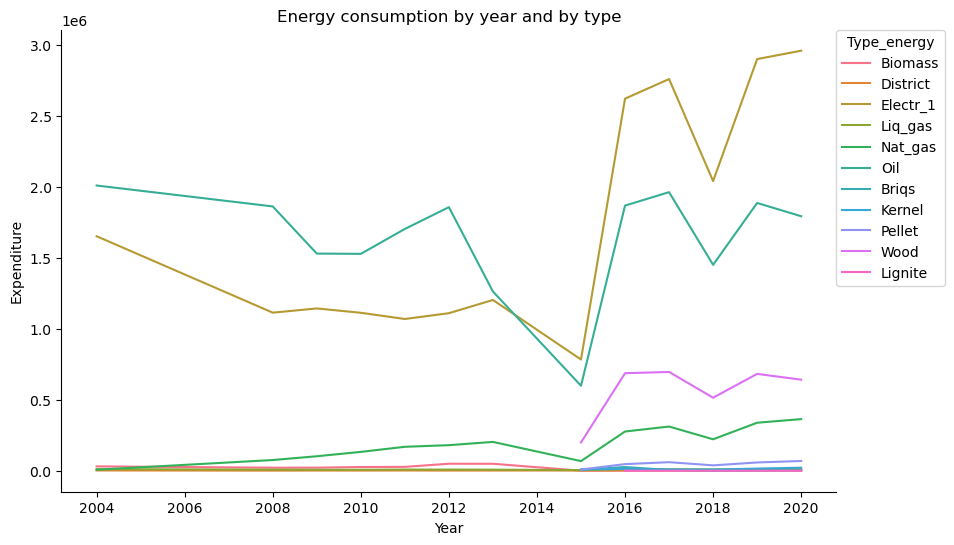

In [22]:
gr_data = data.groupby(['Year', 'Type_energy'])['Expenditure'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.set_palette("husl")

sns.lineplot(data=gr_data, x='Year', y='Expenditure', hue='Type_energy')
plt.title('Energy consumption by year and by type')
plt.xlabel('Year')
plt.ylabel('Expenditure')
plt.legend(title='Type_energy', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=10)
sns.despine()

plt.show()

We see what is consumed the most Electr_1 and Oil. Let's see more energy consumption by location.

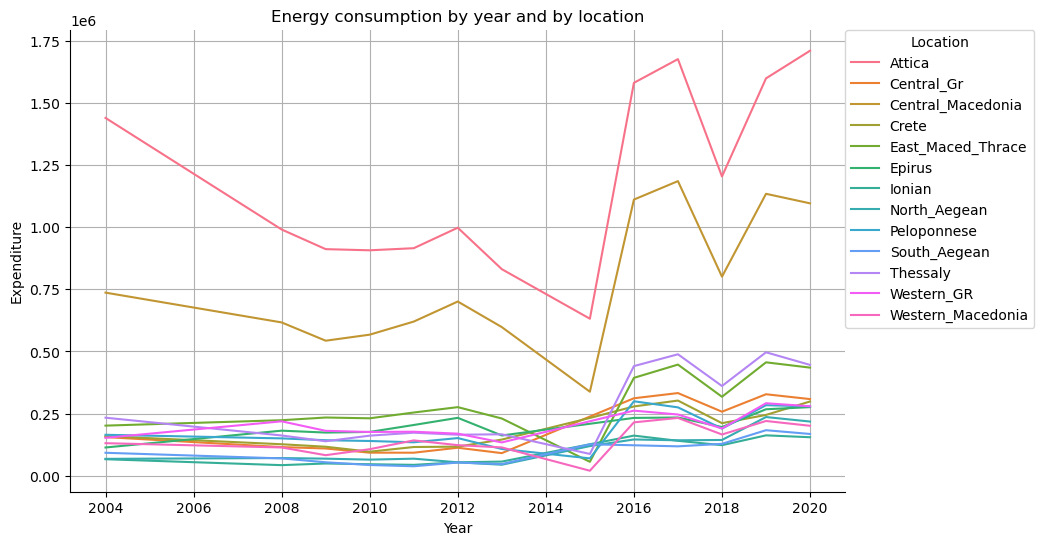

In [23]:
grouped_data = data.groupby(['Year', 'Location'])['Expenditure'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.set_palette("Dark2")

sns.lineplot(data=grouped_data, x='Year', y='Expenditure', hue='Location')
plt.title('Energy consumption by year and by location')
plt.xlabel('Year')
plt.ylabel('Expenditure')
plt.legend(title='Location', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=10)
sns.despine()

plt.grid(True)
plt.show()




We observe an overall increase in energy consumption across all areas of Greece after 2015, attributed to the crisis. Notably, Attica and Central Macedonia emerge as the regions with the highest energy consumption. Let's examine the average temperature by year and location to identify any anomalies that could have had a significant impact on consumption.

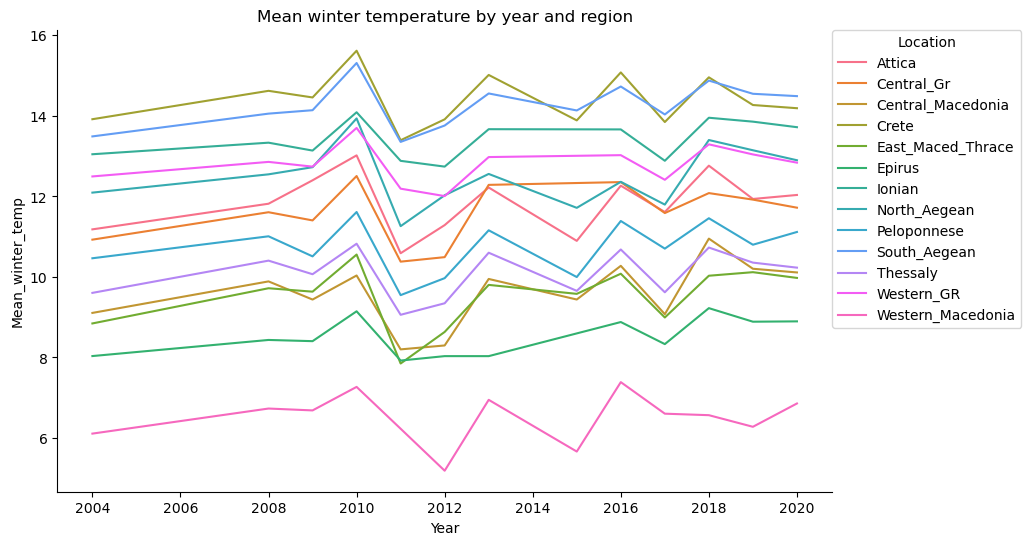

In [24]:
a = data.groupby(['Year', 'Location'])['Mean_winter_temp'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.set_palette("Dark2")

sns.lineplot(data=a, x='Year', y='Mean_winter_temp', hue='Location')
plt.title('Mean winter temperature by year and region')
plt.xlabel('Year')
plt.ylabel('Mean_winter_temp')
plt.legend(title='Location', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=10)
sns.despine()

plt.show()

From the graph we see that there were no major anomalies in temperature. Let's look at the cost per unit of energy by energy type and year.

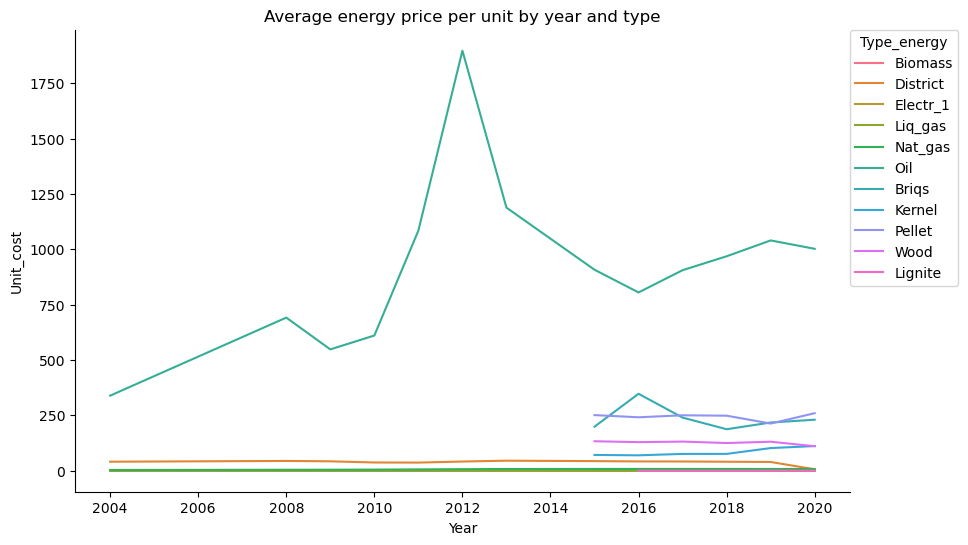

In [25]:
cost_data = data.groupby(['Year', 'Type_energy'])['Unit_cost'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.set_palette("Set2")

sns.lineplot(data=cost_data, x='Year', y='Unit_cost', hue='Type_energy')
plt.title('Average energy price per unit by year and type')
plt.xlabel('Year')
plt.ylabel('Unit_cost')
plt.legend(title='Type_energy', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=10)
sns.despine()

plt.show()

So we see that the most expensive cost to households is Oil. Let's take a look at energy consumption in a household by number of occupants.

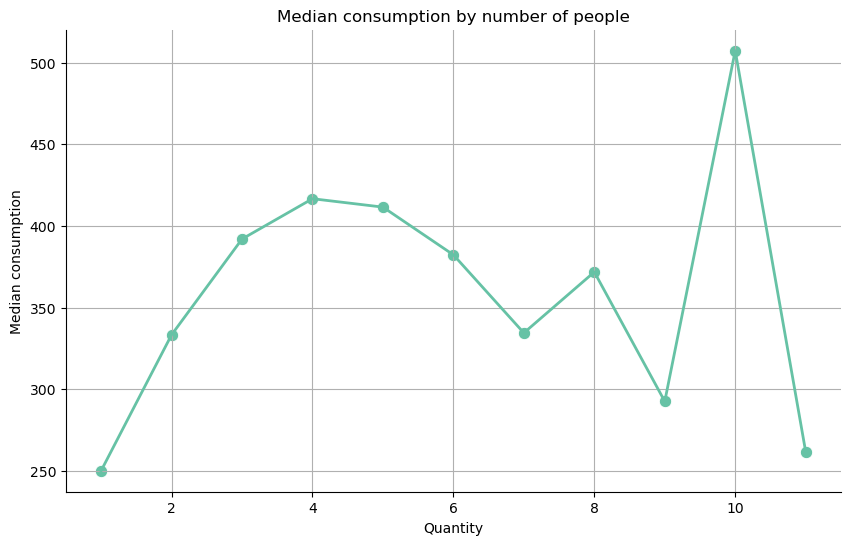

In [26]:
df = data.groupby('Hh_size')['Expenditure'].median().reset_index()

plt.figure(figsize=(10, 6))

sns.scatterplot(data=df, x='Hh_size', y='Expenditure', marker='o', s=80)
sns.lineplot(data=df, x='Hh_size', y='Expenditure', marker=None, linewidth=2)

plt.title('Median consumption by number of people')
plt.xlabel('Quantity')
plt.ylabel('Median consumption')
plt.grid(True)
sns.despine()

plt.show()

We observe that the consumption of 10 individuals is remarkably high. Logically, one might expect that the more tenants there are, the higher the consumption would be. However, this is not always the case. For instance, families with children, even if consisting of 3-5 people, can have a consumption level exceeding that of 3-5 adults.

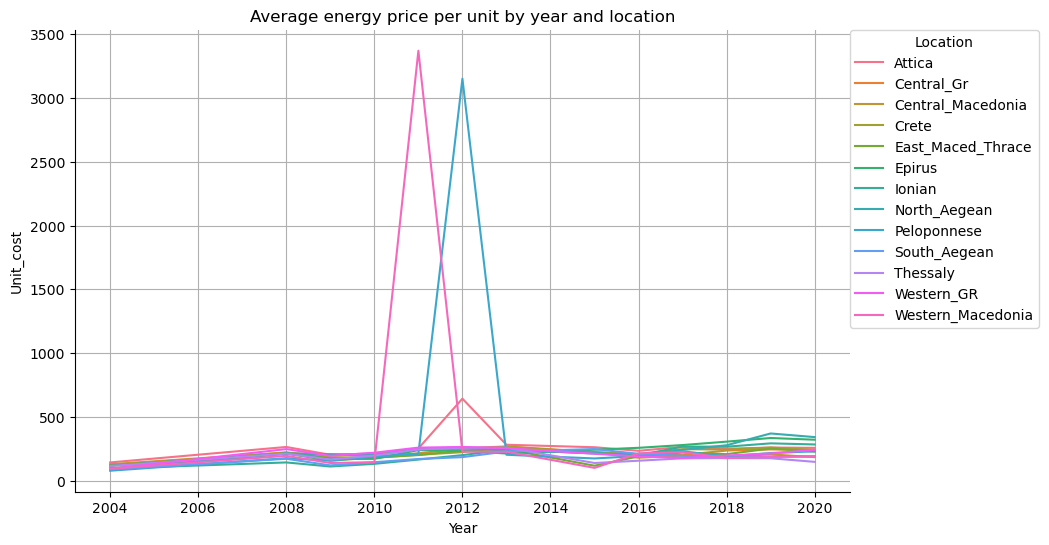

In [27]:
costt_data = data.groupby(['Year', 'Location'])['Unit_cost'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.set_palette("husl")

sns.lineplot(data=costt_data, x='Year', y='Unit_cost', hue='Location')
plt.title('Average energy price per unit by year and location')
plt.xlabel('Year')
plt.ylabel('Unit_cost')
plt.legend(title='Location', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=10)
sns.despine()

plt.grid(True)
plt.show()


Observing the data, we note that the price per unit of energy remains relatively consistent across all regions, with minor variations. Notably, in some years, Western Macedonia, Peloponnese, and Attica experienced significantly higher prices.

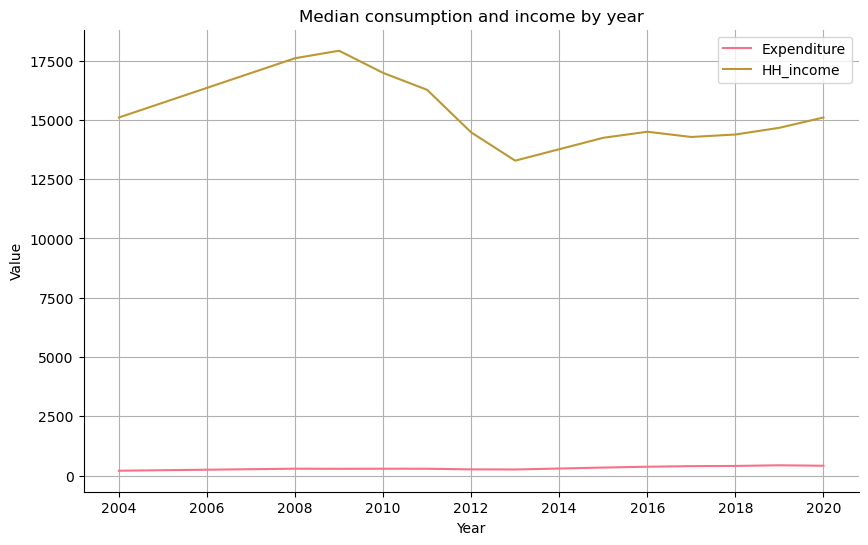

In [28]:
median_data = data.groupby('Year')[['Expenditure', 'HH_income']].median().reset_index()

plt.figure(figsize=(10, 6))

sns.lineplot(data=median_data, x='Year', y='Expenditure', label='Expenditure')
sns.lineplot(data=median_data, x='Year', y='HH_income', label='HH_income')

plt.title('Median consumption and income by year')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
sns.despine()

plt.show()

According to the graph we see that the median consumption of households by year is the same even despite the income.

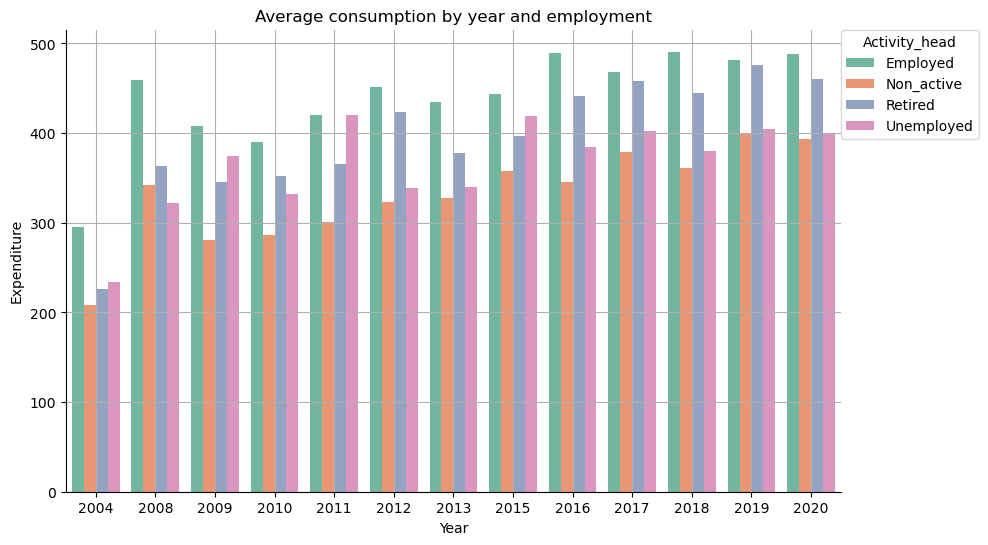

In [29]:
avg_expenditure = data.groupby(['Year', 'Activity_head'])['Expenditure'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.set_palette("Set2")

sns.barplot(data=avg_expenditure, x='Year', y='Expenditure', hue='Activity_head')
plt.title('Average consumption by year and employment')
plt.xlabel('Year')
plt.ylabel('Expenditure')
plt.legend(title='Activity_head', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=10)
sns.despine()

plt.grid(True)
plt.show()

Based on the graph above, there isn't a significant difference in consumption based on employment type. However, it is evident that individuals who are employed and retired tend to consume slightly more than those who are neither employed nor unemployed.

Key points:

- Electricity and Oil have high consumption.
- All regions of Greece experienced an increase in consumption after 2015 due to the crisis.
- The most expensive cost to households is Oil.
- People who are employed and retired consume slightly more than people who are neither employed nor unemployed.

## Segmentation

Let's get to segmentation.

We're going to encode the data now.

In [30]:
encoded_data = pd.get_dummies(data, columns=['Type_energy','Location','Cook_type','Heating_type','Activity_head'])

Delete the household id.

In [31]:
encoded_data = encoded_data.drop(columns=['Hh_ID'])

Standardizing the data.

In [32]:
columns_to_scale = ['Year', 'Quantity','Expenditure','Unit_cost','Mean_winter_temp','Month','Urb_degree',\
                    'Biomass_number','Biomass_main','Hh_size','Age_head','Employed','Unemployed','Retired',\
                    'Non_active','HH_income','Children','Kid_mean_age','Baby','Hh_mean_age']

scaler = StandardScaler()

encoded_data[columns_to_scale] = scaler.fit_transform(encoded_data[columns_to_scale])

Let's select the optimal number of clusters.

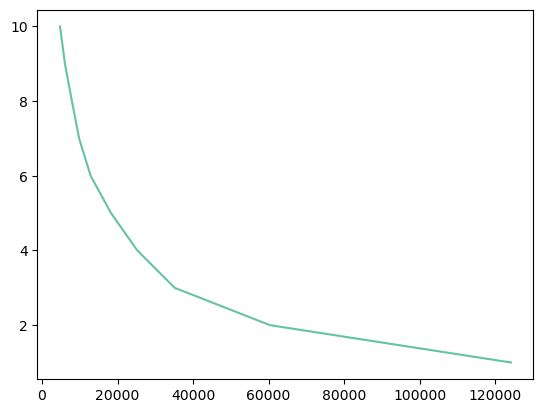

In [33]:
wcss=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init="k-means++").fit(encoded_data[['Expenditure']])
    wcss.append(kmeans.inertia_)
plt.plot(wcss, range(1,11))    

The optimal number of clusters is 3. Let's perform clustering by consumption.

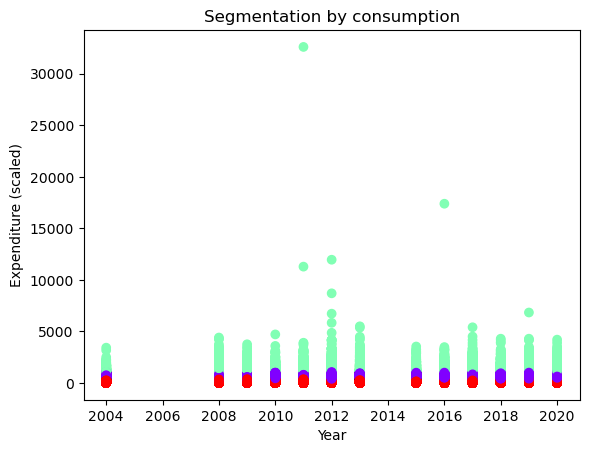

In [34]:
column_for_clustering = 'Expenditure'
cluster = encoded_data[[column_for_clustering]]

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

kmeans.fit(cluster)

# Adding cluster labels to a DataFrame
data['Cluster'] = kmeans.labels_

# Visualization of results
plt.scatter(data['Year'], data[column_for_clustering], c=data['Cluster'], cmap='rainbow')
plt.xlabel('Year')
plt.ylabel('Expenditure (scaled)')
plt.title('Segmentation by consumption')
plt.show()

So, a column is added to the dataset that contains the cluster number. Let's examine how these three types of households differ from each other in terms of consumption.

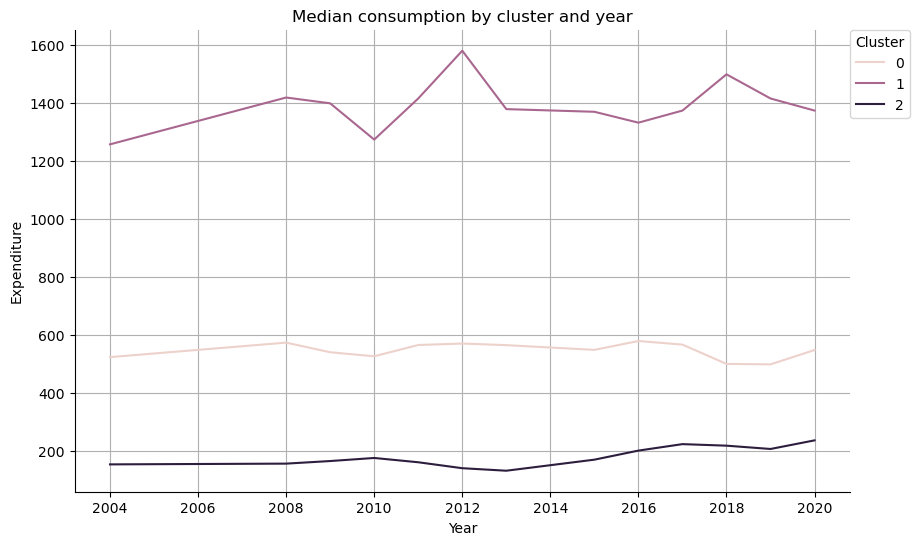

In [35]:
median_data = data.groupby(['Cluster', 'Year'])['Expenditure'].median().reset_index()

plt.figure(figsize=(10, 6))
sns.set_palette("husl")

sns.lineplot(data=median_data, x='Year', y='Expenditure', hue='Cluster')
plt.title('Median consumption by cluster and year')
plt.xlabel('Year')
plt.ylabel('Expenditure')
plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=10)
sns.despine()

plt.grid(True)
plt.show()

Above in the graph, we observe the median consumption by year and cluster. Cluster 1 exhibits the highest energy consumption, followed by cluster 0, with the lowest consumption observed in cluster 2.

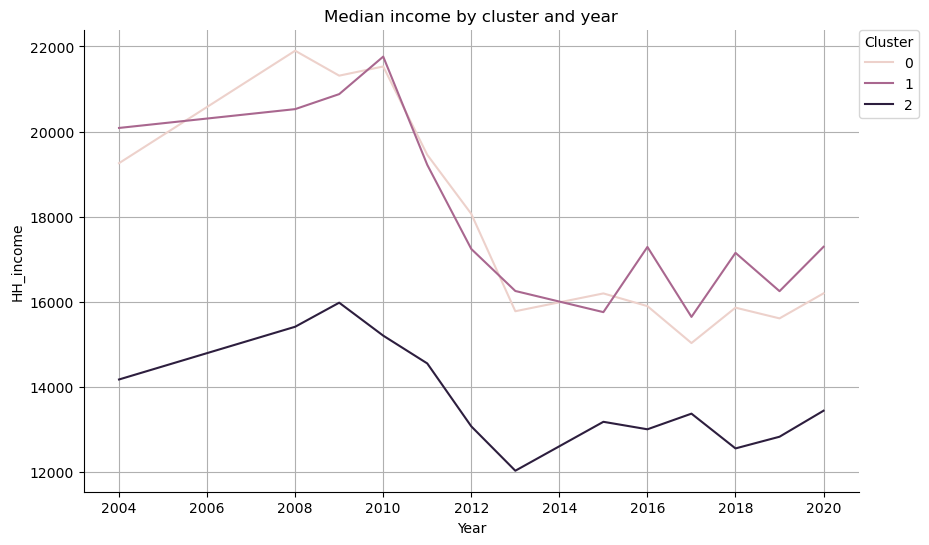

In [36]:
median_data = data.groupby(['Cluster', 'Year'])['HH_income'].median().reset_index()

plt.figure(figsize=(10, 6))
sns.set_palette("husl")

sns.lineplot(data=median_data, x='Year', y='HH_income', hue='Cluster')
plt.title('Median income by cluster and year')
plt.xlabel('Year')
plt.ylabel('HH_income')
plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=10)
sns.despine()

plt.grid(True)
plt.show()

Clusters 0 and 1 have roughly similar incomes, but households in cluster 1 consume more energy than those in cluster 0. In contrast, households in cluster 2 consume less energy and have lower incomes compared to those in clusters 0 and 1.

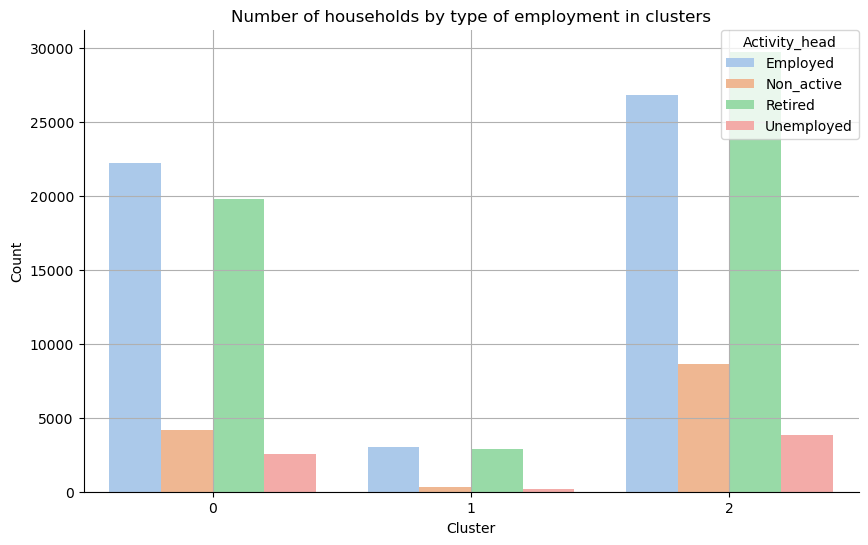

In [37]:

count_data = data.groupby(['Cluster', 'Activity_head']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.set_palette("pastel")

sns.barplot(data=count_data, x='Cluster', y='Count', hue='Activity_head')
plt.title('Number of households by type of employment in clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Activity_head', loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=10)
sns.despine()

plt.grid(True)
plt.show()

All employment categories are present in all clusters, in cluster number 1 the total number is smaller, but this is due to the fact that there are simply not enough of them, and so there is no difference between clusters.

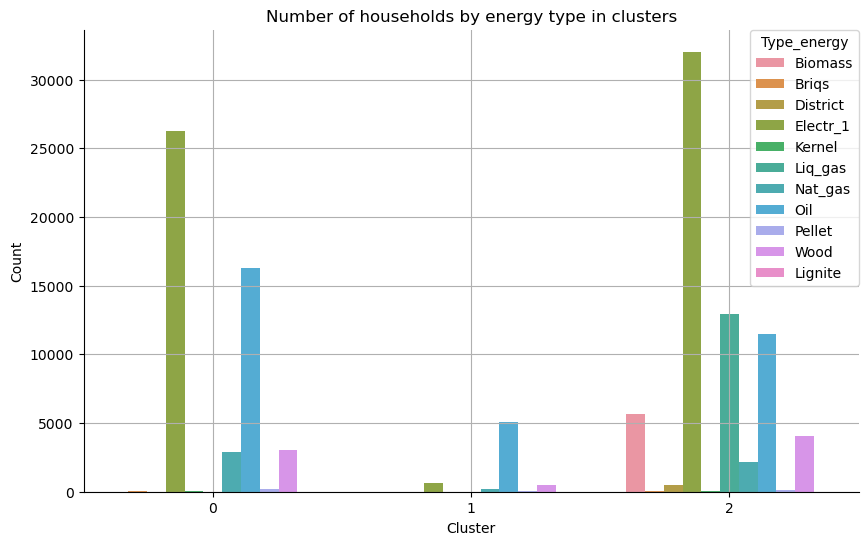

In [38]:
count_data = data.groupby(['Cluster', 'Type_energy']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.set_palette("pastel")

sns.barplot(data=count_data, x='Cluster', y='Count', hue='Type_energy')
plt.title('Number of households by energy type in clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Type_energy', loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=10)
sns.despine()

plt.grid(True)
plt.show()

In Cluster 1, most households use oil, and this is the most expensive type of energy. But oil is also used by households in clusters 0 and 2, so we cannot claim that this is what influenced the split. We also see that cluster 0 and 2 are dominated by households that consume Electr_1.

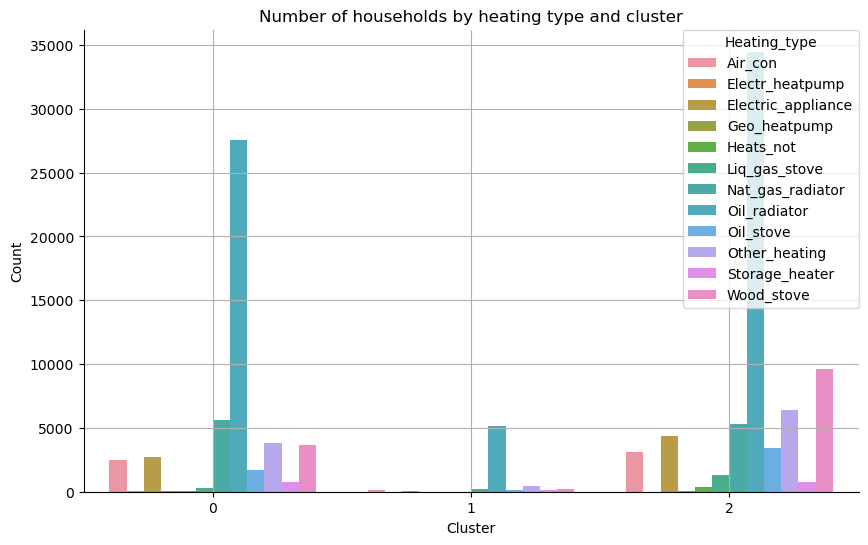

In [39]:
count_heating_data = data.groupby(['Cluster', 'Heating_type']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.set_palette("pastel")

sns.barplot(data=count_heating_data, x='Cluster', y='Count', hue='Heating_type')
plt.title('Number of households by heating type and cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Heating_type', loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=10)
sns.despine()

plt.grid(True)
plt.show()

From the graph above, it is difficult to identify any feature that would make a difference between the clusters. However, we observe that in all clusters, the predominant heating type is an oil radiator.

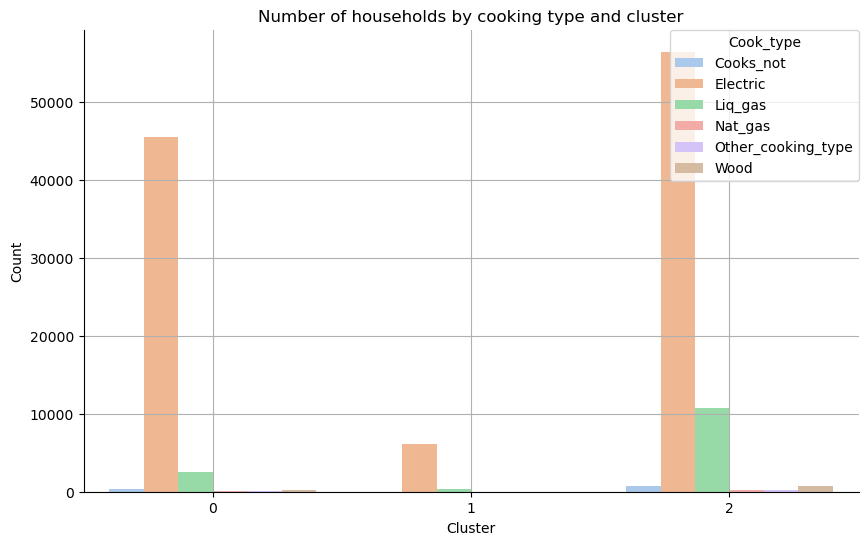

In [40]:
count_heating_data = data.groupby(['Cluster', 'Cook_type']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.set_palette("pastel")

sns.barplot(data=count_heating_data, x='Cluster', y='Count', hue='Cook_type')
plt.title('Number of households by cooking type and cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Cook_type', loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=10)
sns.despine()

plt.grid(True)
plt.show()

The last chart don't show any obvious differences. In all clusters, the Electric cooking type predominates.

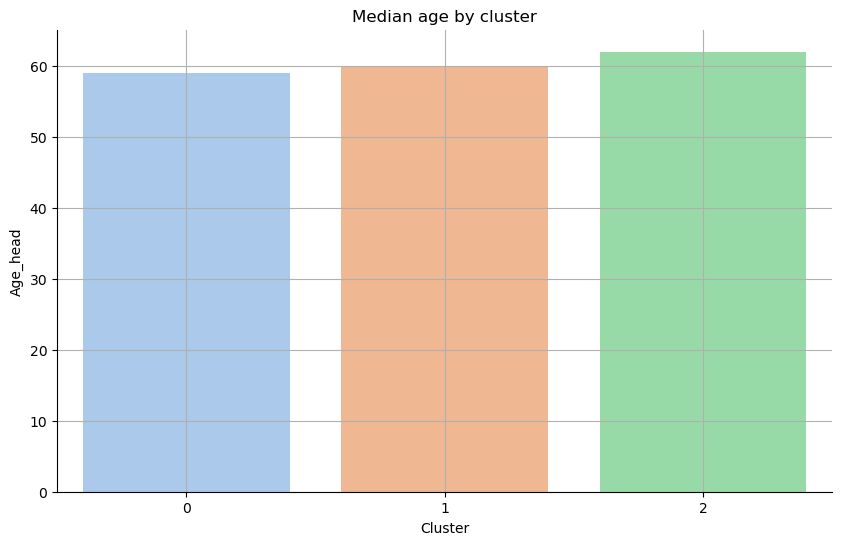

In [41]:
median_age_data = data.groupby('Cluster')['Age_head'].median().reset_index()

plt.figure(figsize=(10, 6))
sns.set_palette("pastel")

sns.barplot(data=median_age_data, x='Cluster', y='Age_head')
plt.title('Median age by cluster')
plt.xlabel('Cluster')
plt.ylabel('Age_head')
sns.despine()

plt.grid(True)
plt.show()

As for age, it is almost the same in all clusters.

Thus, the most important distinguishing features between clusters are household income and consumption. Cluster 0 exhibits high income and medium consumption, Cluster 1 shows high consumption and high income, while Cluster 2 has low consumption and low income compared to the preceding clusters.

## Conclusion

In summary, households in Greece can be categorized into three segments: the first comprises those who consume little energy and have lower incomes, the second consists of those with higher incomes and increased consumption compared to the first group, and the third encompasses those with both high incomes and high energy consumption.